# full_automated_calibration
1. imports
2. robot initialisation and checks
3. finding flow_rate_aspirate
3. loop pipetting using 5 point initialisation parameters


### Imports

In [1]:
#General Imports
from datetime import datetime, date
import os
import time
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import re
from sklearn.linear_model import LinearRegression

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



### Robot initialisation and checks

In [ ]:
#Import robot related packages and run setup
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False #askpablo

In [ ]:
#Initialization of variables for platform objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)

In [ ]:
#Check if balance is connected
balance.zero() #to tare
balance.toggleRecord(True) # turn on and record weight
time.sleep(5) # do previous action for 5s
print(balance.buffer_df.iloc[-1]) #iloc can take -1, loc needs to be 839 loc[839,["Time","Value","Factor","Baseline","Mass"]]. -1 is last line. to find number of last line, print(balance.buffer_df)
balance.toggleRecord(False) #turn off

In [ ]:
#Establish initial height of liquid on the source vial
pipette_name = 'rLine1000'
initial_liquid_level = 11.5 # in mm

In [ ]:
#Liquid information
liquid_name = "Viscosity_std_505"
density = 0.8683
pipette_name = 'rLine1000'

### Finding flow_rate_aspirate

In [2]:
#%%This cell can be used to measure the mass change profiles when you aspirate a liquid at different speed rates.
#The run is automatically stopped when the mass change derivative is close to 0
#folder to save files in/get files from
REPO = 'viscosity_liquid_transfer_Pablo'
folder = os.getcwd().split(REPO)[0]+REPO+r'\Sartorious_experiments\Mass_balance_flow_Rate\Calibration'

#getting datetime info to save file as todays date
today = date.today()
today = today.strftime("%Y-%m-%d")
now = datetime.now(tz=None)
now = now.strftime("%H-%M-%S")
if  not os.path.exists(folder+'\\'+today):
    os.mkdir(folder+'\\'+today)
folder = folder+'\\'+today

# Setting starting parameters
speed =  265
volume=1000
liquid_name = 'Viscosity_std_505'
filename = folder + '/' +'/'+ today + "_" + now[:-3] + '_' +liquid_name+'_'+str(speed).replace('.','_') + ".csv"

#Moving to balance to aspirate
if mover.getToolPosition()[0] != balance_deck.wells['A1'].from_top((0,0,-10)):
    mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-10)),descent_speed_fraction=0.25)

#Starting balance measurement
time.sleep(5)
balance.zero(wait=5)
balance.clearCache()
balance.toggleRecord(on=True)
time.sleep(15)


liquid.aspirate(volume, speed=speed)
#Switching the balance off after change in mass is less than 0.05
while True:
    data = balance.buffer_df
    data['Mass_smooth']= signal.savgol_filter(data['Mass'],91,1)
    data['Mass_derivative_smooth']=data['Mass_smooth'].diff()
    condition=data['Mass_derivative_smooth'].rolling(30).mean().iloc[-1]
    if condition>-0.05:
        break
print('loop stopped')


#dispensing liquid at the rate specified
time.sleep(10)
mover.setSpeed(50)
mover.moveTo(balance_deck.wells['A1'].from_top((0,0,10)))
liquid.dispense(1000, speed=20)
time.sleep(10)
#switching balance off and saving csv
balance.toggleRecord(on=False)
balance.buffer_df.to_csv(filename)

NameError: name 'mover' is not defined

In [3]:
#Temporary: To test sigmoid code
#define files dict and import data to be used in plotting
files_dict = {}
folder_name = r'2023-03-10'
for file in os.listdir(folder_name):
    if '.csv' in file:
        speed = re.split(r'[.\s]\s*',file)[-2]+ '_'+re.split(r'[.\s]\s*',file)[1]
        files_dict[speed] = pd.read_csv(folder_name+r'/'+file,index_col=0)

for key in files_dict:
    files_dict[key]['ts'] = files_dict[key]['Time'].astype('datetime64[ns]').values.astype('float') / 10 ** 9
    files_dict[key]['ts']=files_dict[key]['ts']-files_dict[key]['ts'][0]
    # files_dict[key]['Mass']=files_dict[key]['Mass']-files_dict[key]['Mass'][0]
    files_dict[key]['Mass_analysis_smooth']= signal.savgol_filter(files_dict[key]['Mass'],91,89)
    files_dict[key]['Mass_analysis_derivative_smooth']=files_dict[key]['Mass_analysis_smooth'].diff()

C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\numpy\lib\polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_savitzky_golay.py:223: RankWarning: Polyfit may be poorly conditioned
  _fit_edge(x, 0, window_length, 0, halflen, axis,
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_savitzky_golay.py:226: RankWarning: Polyfit may be poorly conditioned
  _fit_edge(x, n - window_length, n, n - halflen, n, axis,
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_savitzky_golay.py:223: RankWarning: Polyfit may be poorly conditioned
  _fit_edge(x, 0, window_length, 0, halflen, axis,
C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_savitzky_golay.py:226: RankWarning: Polyfit may be poorly conditioned
  _fit_edge(x, n - window_length, n, n - halflen, n, axis,
C:\Users\admin\

[67.11418893944025, 165.08759689331055, 1, -800.7265531354448]
[1020.96355702124, 124.17255222797394, 1, 107.07800199058744]


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


[-31.65270886912861, 83.60035610198975, 1, -1305.008370108258]
[2993.724796571308, 126.28560066223145, 1, 2059.585352297453]
[2025.9219620840356, 119.34555292129517, 1, 1090.9082492097552]
[-2254.9067602494515, 76.4192967414856, 1, -3183.072035753728]
[3046.05635940457, 50.74319911003113, 1, 2123.4281183696576]
[4345.56466542266, 46.13151955604553, 1, 3424.539250155195]
[30.893207221739765, 41.550699949264526, 1, -866.9640901344368]
[5822.078294850482, 37.73678779602051, 1, 4903.384262517487]
[11997.481779789852, 30.626328706741333, 1, 11092.776045063672]
[11972.363559620931, 29.514076709747314, 1, 11064.88930766007]


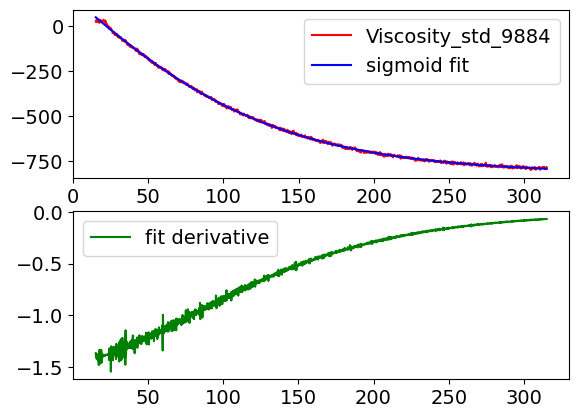

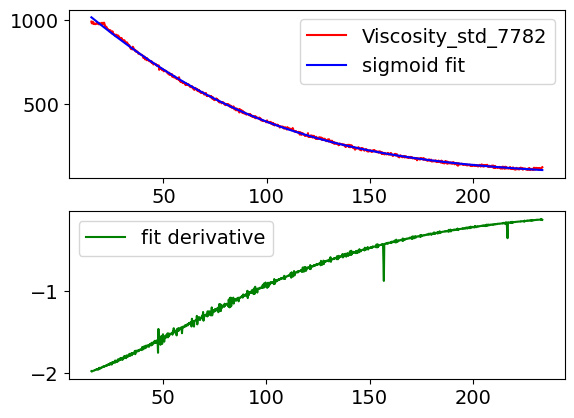

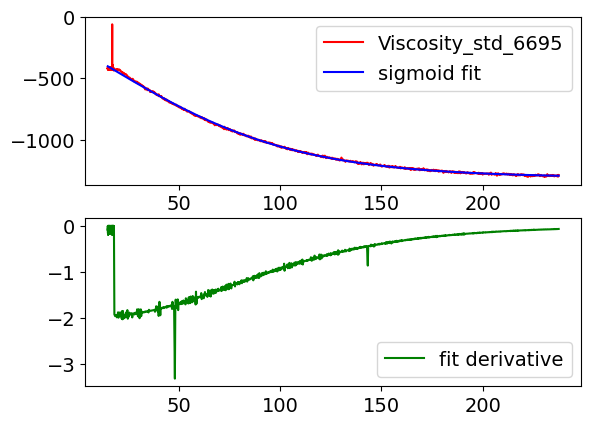

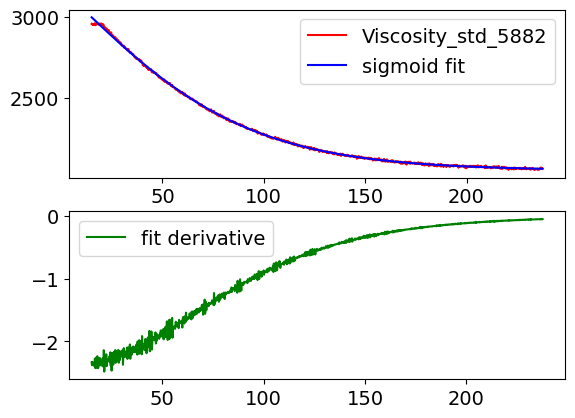

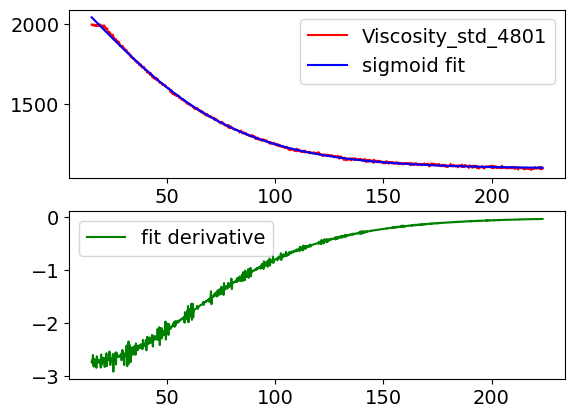

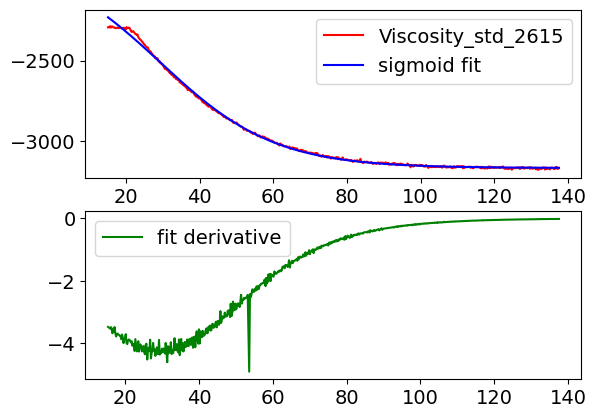

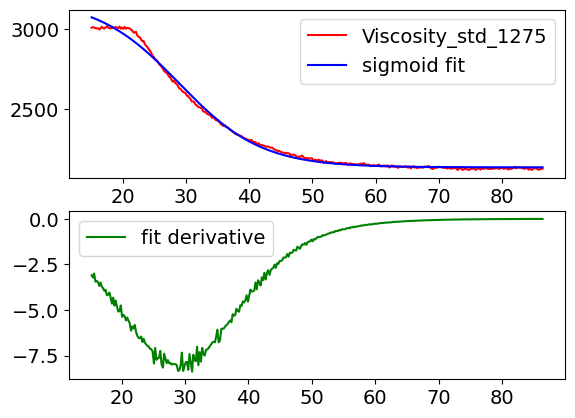

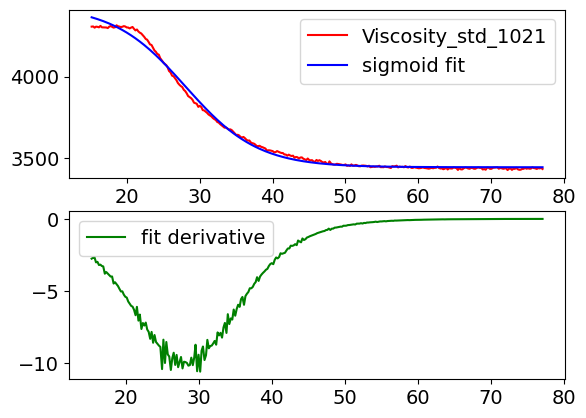

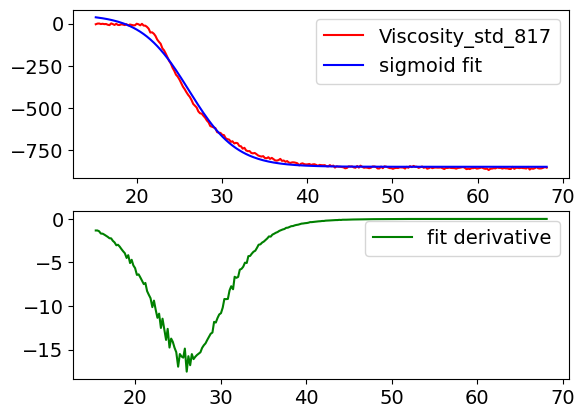

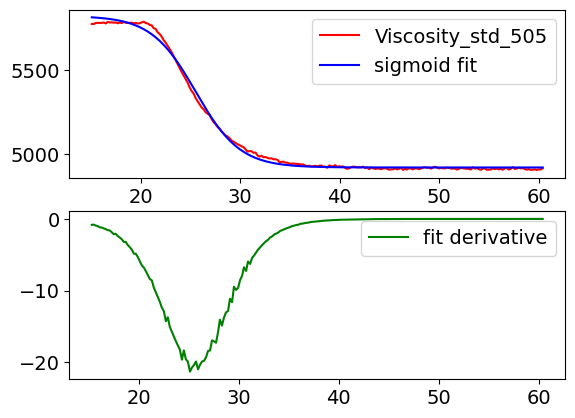

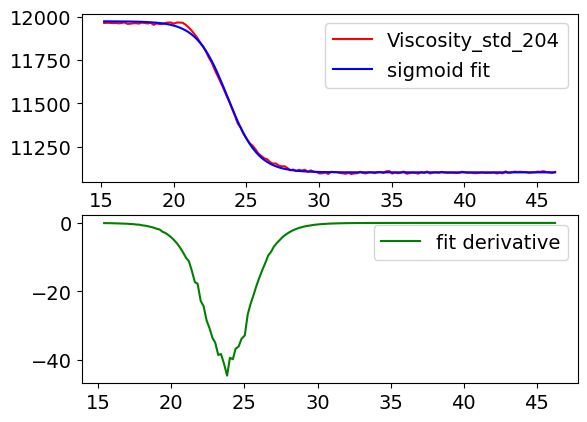

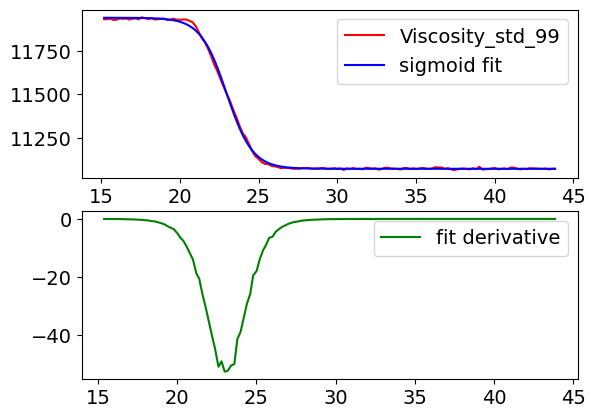

In [4]:
#Defining sigmoid function (to smooth out jagged curve and get a better derivative)
from scipy.optimize import curve_fit
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

#plotting time 
for file in files_dict.keys():

    xdata = files_dict[file].where(files_dict[file]['ts']>15).dropna()['ts']
    ydata = files_dict[file].where(files_dict[file]['ts']>15).dropna()['Mass']

    p0 = [max(ydata)+30, np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
    print(p0)

    popt, pcov = curve_fit(sigmoid, xdata, ydata,p0)

    yfit = sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])

    fig,axs = plt.subplots(2)
    axs[0].plot(xdata,ydata,color = 'red', label=file.split('_265')[0][17:])
    axs[0].plot(xdata,yfit,color = 'blue', label= 'sigmoid fit')
    axs[0].legend()
    axs[1].plot(xdata,yfit.diff(),color = 'green', label= 'fit derivative')
    axs[1].legend()

In [5]:
files_dict[file].dropna()

,Time,Value,Factor,Baseline,Mass,Mass_smooth,Mass_derivative_smooth,ts,Mass_analysis_smooth,Mass_analysis_derivative_smooth
1,2023-03-10 17:09:26.262551,273676,6.862879,191718.998701,11942.072137,11934.919699,-0.036178,0.161089,1.194350e+04,6.482425e+00
2,2023-03-10 17:09:26.461308,273682,6.862879,191718.998701,11942.946405,11934.883520,-0.036178,0.359846,1.194309e+04,-4.141554e-01
3,2023-03-10 17:09:26.664098,273713,6.862879,191718.998701,11947.463460,11934.847342,-0.036178,0.562636,1.194074e+04,-2.354412e+00
4,2023-03-10 17:09:26.862839,273596,6.862879,191718.998701,11930.415222,11934.811164,-0.036178,0.761377,1.193847e+04,-2.265099e+00
5,2023-03-10 17:09:27.063484,273628,6.862879,191718.998701,11935.077988,11934.774985,-0.036178,0.962022,1.193682e+04,-1.649102e+00
...,...,...,...,...,...,...,...,...,...,...
215,2023-03-10 17:10:09.143232,267700,6.862879,191718.998701,11071.300611,11071.685387,-0.047322,43.041770,-1.782501e-263,-1.082807e-268
216,2023-03-10 17:10:09.343165,267714,6.862879,191718.998701,11073.340571,11071.638065,-0.047322,43.241703,-1.782833e-263,-3.317124e-267
217,2023-03-10 17:10:09.548246,267680,6.862879,191718.998701,11068.386382,11071.590743,-0.047322,43.446784,-1.782619e-263,2.132899e-267
218,2023-03-10 17:10:09.743607,267704,6.862879,191718.998701,11071.883456,11071.543421,-0.047322,43.642145,-1.782751e-263,-1.318201e-267


In [24]:
xdata = files_dict[file].where(files_dict[file]['ts']>15).dropna()['ts']
ydata = files_dict[file].where(files_dict[file]['ts']>15).dropna()['Mass']

p0 = [max(ydata)+30, np.median(xdata),1,min(ydata)] # this is an mandatory initial guess
print(p0)

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0)

yfit = sigmoid(xdata,popt[0],popt[1],popt[2],popt[3])

density = 0.8578
#get the index of the minimum differentiated mass/time function
min_index = np.where(yfit.diff() == yfit.diff().min())[0][0]
#using min index to get average of dM/dt at min
flow_rate_aspirate = - (yfit.diff()[min_index-5:min_index+5].mean() / density)



[11972.363559620931, 29.514076709747314, 1, 11064.88930766007]


In [25]:
flow_rate_aspirate 

54.469778174822636

### Loop pipetting using 5 point initialisation parameters

In [ ]:
#New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error', 'Transfer_Observation', 'Comment'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool,'Transfer_Observation':str,'Comment':str})

#load dataframe if experiment was done halfway previously
df = pd.read_csv(liquid_name+'.csv')

In [ ]:
liquids_dict = {
  liquid_name :{ # why so many dict #askpablo
        "rLine1000": {
            "aspiration_rate": flow_rate_aspirate,
            "dispense_rate": flow_rate_aspirate,
            "blow_out" : False,
            "delay_aspirate" : 10, 
            "delay_dispense" : 10, 
            "delay_blow_out" : 0, 
            },
    }

}

In [ ]:
#Check if new tip is required
pipette.mover.setSpeed(50)
pipette.mover.setHandedness(False)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#setup for loops
#TO BE CHANGED (sometimes)
iterations = 5
volumes_list = [1000, 500, 300]

#NOT TO BE CHANGED
liquid_level = initial_liquid_level
counter = 1

#while loop
while counter <= iterations:

    #hardcoding aspirate and dispense rates:
    if counter == 1:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = flow_rate_aspirate
    if counter == 2:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 1.25 * flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 1.25 * flow_rate_aspirate
    if counter == 3:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 1.25 * flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 0.1 * flow_rate_aspirate
    if counter == 4:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 0.1 * flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 1.25 * flow_rate_aspirate
    if counter == 5:
        liquids_dict[liquid_name][pipette_name]['aspiration_rate'] = 0.1 * flow_rate_aspirate
        liquids_dict[liquid_name][pipette_name]['dispense_rate'] = 0.1 * flow_rate_aspirate


    #for loop
    for item in volumes_list:
        volume = item
        #liquid transfer
        #transfer start
        start = time.time() 

        #aspirate step
        pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5))) 
        pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

        pipette.touchTip(source.wells['A1']) 

        #dispense step
        pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5))) 
        balance.tare() 
        balance.clearCache() 
        balance.toggleRecord(True) 
        time.sleep(5)
        pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])
        time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

        #blowout step
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True: 
            pipette.liquid.blowout(home=False)
            time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out']) 

        #transfer termination
        finish = time.time() 
        time_m = finish - start

        pipette.mover.safeMoveTo(source.wells['A1'].top) 
        time.sleep(5)
        balance.toggleRecord(False) 
        if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
            pipette.liquid.home() 

        #do blowout
        pipette.liquid.blowout(home=False) 
        time.sleep(5)
        pipette.touchTip(source.wells['A1'])
        pipette.liquid.home()
        time.sleep(5)
        pipette.liquid.blowout(home=False)
        time.sleep(5)
        pipette.touchTip(source.wells['A1'])
        pipette.liquid.home()
        time.sleep(5)
        pipette.liquid.blowout(home=False)
        time.sleep(5)
        pipette.touchTip(source.wells['A1'])
        pipette.liquid.home()

        #record transfer values 
        #calculating mass error functions
        m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000 
        error = (m-density*volume/1000)/(density/1000*volume)*100

        #making new dataframe + filling it in
        df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
        df.iloc[-1,-4] = time_m
        df.iloc[-1,2] = volume
        df.iloc[-1, 0] = liquid_name
        df.iloc[-1, 1] = pipette_name
        df.iloc[-1,-5] = density
        df.iloc[-1, -3] = m
        df.iloc[-1,-2]= error

        #change liquid levels
        liquid_level = liquid_level - 1.2*m/density   

        #printing checks
        print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: "str(volume))     

        #liquid level checks
        if (1.2*m/density > 1.2) or (1.2*m/density < 0):
            break
        if (liquid_level > initial_liquid_level) or (liquid_level < 6):
            break

    
    counter += 1



In [ ]:
#To save the csv
df.to_csv(liquid_name+'.csv', index = False)